In [2]:
from enum import Enum
import random
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import copy

from queue import PriorityQueue, SimpleQueue

In [62]:
# Directional Vectors
DY = [-1, 1, 0, 0]
DX = [0, 0, 1, -1]   

# Represents the different types of Cells
class Cell(Enum):
    BLOCKED = 0
    OPEN = 1
    FIRE = 2
    BUTTON = 3

    def __eq__(self, other):
        if isinstance(other, Cell):
            return self.value == other.value
        return self.value == other
    
# Represents the Ship
class Ship: 
    def __init__(self, D, q, seed, init=True):
        self.D = D
        self.q = q
        self.seed = seed
        self.time = 0
        self.board = []
        self.open_cells = []
        self.fire_cells = []
        self.bot_location = ()
        
        if init:
            self.init_board()
            self.init_bot()
            self.init_fire()
            self.init_button()
    
    def init_board(self):
        n = self.D
        random.seed(self.seed)
        
        self.board = [[Cell.BLOCKED for _ in range(n)] for _ in range(n)]
        rand_row = random.randint(0, n - 1)
        rand_col = random.randint(0, n - 1)
        
        self.board[rand_row][rand_col] = Cell.OPEN
        valid_cells = set()
        open_cells = [(rand_row, rand_col)]
        valid_cells.add((rand_row, rand_col))

        while True:
            candidates = self.get_candidates(valid_cells)
            if not candidates:
                break

            rand_cell = random.choice(candidates)
            r, c = rand_cell
            self.board[r][c] = Cell.OPEN
            valid_cells.add((r, c))
            open_cells.append((r, c))

        # Collect all open cells with exactly 1 open neighbor
        dead_ends = []
        for oc in open_cells:
            r, c = oc
            open_neighbors = self.get_neighbor_count(r, c, Cell.OPEN)
            if open_neighbors == 1:
                dead_ends.append(oc)

        # Open approximately half of the dead ends
        num_dead_ends = len(dead_ends)
        while len(dead_ends) > num_dead_ends // 2:

            # Pick a random dead end and open one of it's neighbors
            rand_idx = random.randint(0, len(dead_ends) - 1)
            r, c = dead_ends[rand_idx]
            closed_neighbors = self.get_neighbors(r, c, Cell.BLOCKED)
            if closed_neighbors:
                rand_cell = random.choice(closed_neighbors)
                nr, nc = rand_cell
                self.board[nr][nc] = Cell.OPEN
                open_cells.append((nr, nc))
                dead_ends.pop(rand_idx)

                # Check for newly opened dead ends
                open_neighbors = self.get_neighbors(nr, nc, Cell.OPEN)
                for neighbor in open_neighbors:
                    r, c = neighbor

                    # If this pair is also a dead end, remove it
                    try:
                        idx = dead_ends.index((r, c))
                        dead_ends.pop(idx)
                    except ValueError: # was not a dead end
                        continue
        ### print(len(dead_ends), num_dead_ends)

        self.open_cells = open_cells

    def deepcopy(self, D, q, seed):
        new_ship = Ship(D, q, seed, init=False)
        new_ship.board = [row[:] for row in self.board]
        new_ship.bot_location = copy.deepcopy(self.bot_location)
        new_ship.button_location = copy.deepcopy(self.button_location)
        new_ship.fire_cells = [row[:] for row in self.fire_cells]
        new_ship.initial_fire = copy.deepcopy(self.initial_fire)
        new_ship.open_cells = [row[:] for row in self.open_cells]
        new_ship.time = 0

        return new_ship

    def init_bot(self):
        self.bot_location = random.choice(self.open_cells)
    
    def init_fire(self):
        """Randomly selects a cell to catch on fire"""
        open_cell = random.choice(self.open_cells) # Choose a random cell from the open cells
        r, c = open_cell

        self.board[r][c] = Cell.FIRE
        self.fire_cells.append(open_cell)
        self.open_cells.remove(open_cell)

        self.initial_fire = (r, c)

    def init_button(self):
        open_cell = random.choice(self.open_cells)
        r, c = open_cell

        self.board[r][c] = Cell.BUTTON 
        self.button_location = (r, c)


    # Time Steps
    def time_step(self):
        self.advance_fire()
        self.time += 1
    
    def advance_fire(self):
        """Advances fire within a calculated probability"""
        fire_cells = self.fire_cells[:]
        
        for fc in fire_cells:
            r, c = fc
            potential_fire = self.get_neighbors(r, c, Cell.OPEN)

            for cell in potential_fire:
                nr, nc = cell
                ignite = self.ignition_probability(nr, nc)
                
                if ignite: # Ignites the cell and removes it from open cells
                    self.board[nr][nc] = Cell.FIRE
                    self.open_cells.remove(cell)
                    self.fire_cells.append(cell)

    
    # Helper Methods
    def is_valid(self, r, c):
        """Determine if a row x col is within the bounds of the board"""
        return r >= 0 and c >= 0 and r < self.D and c < self.D
    
    def get_neighbors(self, r, c, target):
        """Get all of the valid neighbors of the desired type"""
        res = []
        for i in range(4):
            nr = DY[i] + r
            nc = DX[i] + c
            if self.is_valid(nr, nc) and self.board[nr][nc] == target:
                res.append((nr, nc))
        
        return res

    def get_neighbor_count(self, r, c, target):
        """Get the number of valid neighbors of the desired type"""
        return len(self.get_neighbors(r, c, target))

    def get_candidates(self, open_cells):
        n = self.D
        candidates = []
        to_remove = []
        for pair in open_cells:
            r, c = pair
            closed_neighbors = self.get_neighbors(r, c,  Cell.BLOCKED)
            valid_found = 0
            for neighbor in closed_neighbors:
                n_r, n_c = neighbor
                open_neighbors = self.get_neighbor_count(n_r, n_c, Cell.OPEN)
                if open_neighbors == 1:
                    valid_found += 1
                    candidates.append((n_r, n_c))

            if valid_found == 0:
                # print("removing {}".format(pair))
                to_remove.append(pair) 

        for pair in to_remove:
            open_cells.remove(pair)
            
        return candidates
    
    def validate_board(self):
        """Validates that there are no BLOCKED cells with exactly one neighbor"""
        n = self.D
        count = 0
        for i in range(n):
            for j in range(n):
                if self.board[i][j] == Cell.BLOCKED:
                    open_neighbors = self.get_neighbor_count(i, j, Cell.OPEN)
                    if open_neighbors == 1:
                        count += 1
        
        return count == 0
    
    def set_q(self, new_q):
        self.q = new_q

    def ignition_probability(self, r, c):
        """Calculate the probability that any given cell should be ignited, given the formula: 1 - (1 - q)^K"""
        q = self.q # Flammability constant
        K = self.get_neighbor_count(r, c, Cell.FIRE) # Get number of burning neighbors
        probability = 1 - ((1 - q) ** K)
        return random.uniform(0, 1) <= probability

    def simulate_fire(self):
        SIMULATIONS = 25
        deep_copy = [row[:] for row in self.board]
        open_cells_copy = [row[:] for row in self.open_cells]
        seed = self.seed

        random.seed(None)
        fire_freqs = [[0 for _ in range(D)] for _ in range(D)]
        button_r, button_c = self.button_location
        bot_r, bot_c = self.bot_location
        fire_r, fire_c = self.fire_cells[0]
        

        TIME_STEPS_PER = (abs(bot_r - button_r) + abs(bot_c - button_c)) * 1.5
        for i in range(SIMULATIONS):
            print(f"RUNNING SIMULATION {i}")
            # Simulate fire
            steps = 0
            while steps < TIME_STEPS_PER:
                self.advance_fire()
                if self.board[button_r][button_c] == Cell.FIRE:
                    break
                steps += 1

            for fc in self.fire_cells:
                a, b = fc
                fire_freqs[a][b] += 1

            self.board = [row[:] for row in deep_copy]
            self.fire_cells = [(fire_r, fire_c)]
            self.open_cells = [row[:] for row in open_cells_copy]

        for i in range(D):
            for j in range(D):
                fire_freqs[i][j] = float(fire_freqs[i][j] / SIMULATIONS)
        
        random.seed(seed)
        self.board = fire_freqs
        return fire_freqs
                

    # Traversal Algorithms
    def shortest_path(self, src, dst):
        """Calculate the shortest path from SRC to DST if one exists - BFS"""
        n = self.D
        queue = [(src, [src])]
        visited = [[False for _ in range(n)] for _ in range(n)]
        count = 0
        while queue:
            count += 1
            coords, path = queue.pop(0)
            if coords == dst:
                return path

            r, c = coords
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.is_valid(nr, nc) and self.board[nr][nc] == Cell.OPEN and not visited[nr][nc]:
                    visited[nr][nc] = True
                    new_path = path + [(nr, nc)]
                    next_entry = ((nr, nc), new_path)
                    queue.append(next_entry)

        return []

    def early_stop_bfs(self, button, bot, paths=False): # TODO: confirm correctness of this method
        open = SimpleQueue() # fringe
        closed = set() # explored

        bot_dist = -1
        fire_dist = -1 # dist will never be above this value

        bot_path = []
        fire_path = []

        dist = 0
        open.put((dist, (button, [button])))

        while open.qsize() != 0 and (bot_dist == -1 or fire_dist == -1):
            curr = open.get()
            dist, vertex = curr
            coords, path = vertex
            coords_r, coords_c = coords
            if coords == bot:
                bot_dist = dist
                bot_path = path
            if self.board[coords_r][coords_c] == Cell.FIRE:
                if fire_dist == -1 or dist < fire_dist:
                    fire_dist = dist
                    fire_path = path
            else:
                closed.add(coords)
                
                r, c = coords
                for i in range(4):
                    nr = DY[i] + r
                    nc = DX[i] + c
                    if self.is_valid(nr, nc) and self.board[nr][nc] != Cell.BLOCKED and (nr, nc) not in closed:
                        new_path = path + [(nr, nc)]

                        dist = len(new_path) - 1

                        next_entry = (dist, ((nr, nc), new_path))

                        open.put(next_entry)

        if paths:
            return (bot_dist, bot_path), (fire_dist, fire_path)
        return bot_dist, fire_dist

    def astar(self, start, goal, radius=-1):
        open = PriorityQueue() # fringe
        closed = set() # explored
        
        start_r, start_c = start[0], start[1]
        goal_r, goal_c = goal[0], goal[1]

        f = abs(goal_r - start_r) + abs(goal_c - start_c)
        open.put((f, (start, [start])))

        while open.qsize() != 0:
            curr = open.get()
            #print("curr", curr)
            f, vertex = curr
            coords, path = vertex

            if coords == goal:
                return path # SUCCESS
            else:
                closed.add(coords)
                
                r, c = coords
                for i in range(4):
                    nr = DY[i] + r
                    nc = DX[i] + c
                    if self.is_valid(nr, nc) and self.board[nr][nc] != Cell.BLOCKED and (nr, nc) not in closed:
                        if radius >= -1:
                            if (nr, nc) == self.initial_fire:
                                continue
                        if radius >= 0: # self.board[nr][nc] == Cell.OPEN and 
                            if self.board[nr][nc] == Cell.FIRE:
                                continue
                            # check for fire
                        if radius == 1: # BUG: if bot is next to button and fire is also next to button, then bot will not enter button cell
                            if self.get_neighbor_count(nr, nc, Cell.FIRE) > 0:
                                if self.board[nr][nc] != Cell.BUTTON: # ignore if not button
                                    continue
                            # check for neighbor fire

                        new_path = path + [(nr, nc)]

                        g = len(new_path) - 1
                        h = abs(goal_r - nr) + abs(goal_c - nc)

                        f = g + h

                        next_entry = (f, ((nr, nc), new_path))

                        open.put(next_entry)

        return []
        
    def is_path_obstructed(self, path=[]):
        if path == []:
            return True
        for (r, c) in path:
            if self.board[r][c] == Cell.FIRE:
                return True
        return False

    def has_path(self, src, dst):
        """Calculate a path from SRC to DST if one exists - DFS"""
        n = self.D
        stack = [(src, [src])]
        visited = [[False for _ in range(n)] for _ in range(n)]
        while stack:
            coords, path = stack.pop()
            if coords == dst:
                return path

            r, c = coords
            for i in range(4):
                nr = DY[i] + r
                nc = DX[i] + c
                if self.is_valid(nr, nc) and self.board[nr][nc] == Cell.OPEN and not visited[nr][nc]:
                    visited[nr][nc] = True
                    new_path = path + [(nr, nc)]
                    next_entry = ((nr, nc), new_path)
                    stack.append(next_entry)

        return []
        


    # Bot methods
    def is_fail(self):
        r, c = self.button_location
        if self.board[r][c] == Cell.FIRE:
            return True
        
        r, c = self.bot_location
        if self.board[r][c] == Cell.FIRE:
            return True
        
        return False

    def display(self, path = None):
        """Display a grid image of the current board (FOR USE IN NOTEBOOK)"""
        n = self.D
        copy_board = [row[:] for row in self.board]
        if not isinstance(copy_board[0][0], (float, int)):
            for i in range(n):
                for j in range(n):
                    copy_board[i][j] = copy_board[i][j].value

        if path:
            for pair in path:
                r, c = pair
                copy_board[r][c] = 3
                
        image_data = np.array(copy_board)
        plt.imshow(image_data, "Blues")
        # plt.axis("off")
        plt.show()
                      

In [63]:
class Bot:
    def __init__(self, ship: Ship):
        self.ship = ship
        self.bot = ship.bot_location
        self.button = ship.button_location

    def move(self, new_location):
        self.ship.bot_location = new_location
        self.bot = self.ship.bot_location
    
    def bot_1(self):
        path = self.ship.astar(self.bot, self.button)
        if path:
            return path
        return []

    def bot_2(self):
        path = self.ship.astar(self.bot, self.button, radius=0)
        if path:
            return path
        return []

    def bot_3(self):
        path = self.ship.astar(self.bot, self.button, radius=1)
        if path:
            return path
        return []

    def bot_4(self):
        weights = self.ship.simulate_fire()
        
    def simulate(self, bot_query=bot_1, step_limit=-1):
        success = False
        path = [] 
        curr_path_ind = 1

        bot_path = []
        i = 0
        while step_limit < 0 or i < step_limit:
            
            if self.ship.is_path_obstructed(path=path): # TODO: check that path is not obstructed
                # print("invalid path. querying bot again.")
                path = bot_query()
                curr_path_ind = 1

            if path == []:
                success = False
                break

            next = path[curr_path_ind]
            curr_path_ind += 1
            
            bfs_stop = False
            if bfs_stop:
                bot_dist, fire_dist = self.ship.early_stop_bfs(self.button, self.bot)

            i += 1
            
            # print("bot step:", next)

            if next == () or next == (-1, -1): # no next move found
                success = False
                break
            elif bfs_stop:
                if bot_dist == -1:# elif
                    success = False
                    break
                elif bot_dist < fire_dist:
                    success = True
                    i += bot_dist-1
                    break
            else: # move bot
                self.move(next)
                bot_path += [next]
                if self.bot == self.button:
                    success = True
                    break

            self.ship.time_step()

            if self.ship.is_fail():
                success = False
                break
        
        return success, i, bot_path


RUNNING SIMULATION 0
RUNNING SIMULATION 1
RUNNING SIMULATION 2
RUNNING SIMULATION 3
RUNNING SIMULATION 4
RUNNING SIMULATION 5
RUNNING SIMULATION 6
RUNNING SIMULATION 7
RUNNING SIMULATION 8
RUNNING SIMULATION 9
RUNNING SIMULATION 10
RUNNING SIMULATION 11
RUNNING SIMULATION 12
RUNNING SIMULATION 13
RUNNING SIMULATION 14
RUNNING SIMULATION 15
RUNNING SIMULATION 16
RUNNING SIMULATION 17
RUNNING SIMULATION 18
RUNNING SIMULATION 19
RUNNING SIMULATION 20
RUNNING SIMULATION 21
RUNNING SIMULATION 22
RUNNING SIMULATION 23
RUNNING SIMULATION 24
[0.0, 0.32, 0.56, 0.76, 0.88, 0.84, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.96, 0.0, 0.8, 0.64]
[0.16, 0.0, 0.28, 0.0, 0.96, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.92, 0.8]
[0.32, 0.52, 0.0, 0.0, 0.96, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
[0.0, 0.68, 0.0, 0.96, 0.96, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0,

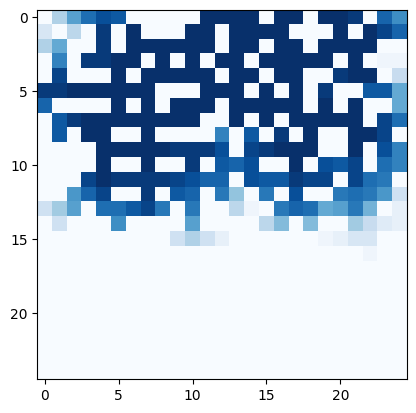

In [67]:
# Generate Ship
D = 100 # ship size
q = .75   # flammability constant
seed = None

ship = Ship(D, q, seed)
for i in ship.simulate_fire():
    print(i)
ship.display()


(False, 11)


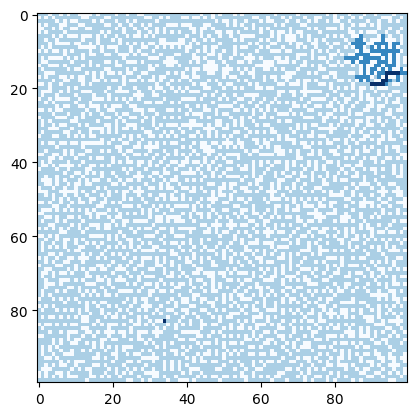

In [235]:
result = test_bot.simulate(test_bot.bot_3)
print(result[:2])
bot_path = result[2]
ship.display(bot_path)

In [236]:
print(bot_path)

[(16, 97), (16, 96), (16, 95), (16, 94), (17, 94), (18, 94), (18, 93), (19, 93), (19, 92), (19, 91), (19, 90)]


In [237]:
# Load Seeds
import json

SEEDS_FILE_PATH = 'seeds.txt'
with open(SEEDS_FILE_PATH, 'r') as seeds_file:
    temp_seeds_dict = json.load(seeds_file)
seeds_file.close()

SEEDS = dict()
for key in temp_seeds_dict:
    SEEDS[int(key)] = temp_seeds_dict[key]

In [238]:
# Data Analysis
import pandas as pd

D = 100

COLUMN_HEADERS = ["BOT", "RESULT", "STEPS", "SEED", "Q", "SIZE"]
SIZES = [25, 50, 75, 100, 150]
Q_VALS = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
NUM_Q = len(Q_VALS)


if False:
    SHIPS = [Ship(D, None, Q_VALS[i]) for i in range(NUM_Q)]
    NUM_SHIPS = len(SHIPS)

    NUM_TRIALS = 100

    trials = []

    # Run every bot NUM_TRIALS times
    """for b in range(1, 5):
        for i in range(NUM_TRIALS):
            s_idx = i % NUM_SHIPS
            q_idx = i % NUM_Q
            seed = SEEDS[s_idx]
            ship = SHIPS[s_idx]
            q = Q_VALS[q_idx]

            bot = Bot(ship)

            bot_func = (
                bot.bot_one() if b == 1 else
                bot.bot_two() if b == 2 else
                bot.bot_three() if b == 3 else
                bot.bot_four()
            )  
            
            result, steps = bot.simulate(bot_func)
            trials.append((b + 1, result, steps, seed, q))"""

    dummy_trials = [
        (random.randint(1, 5), random.choice([True, False]), random.randint(1, 100), None, random.choice(Q_VALS), random.choice(SIZES))
        for _ in range(500)
    ]

    df = pd.DataFrame(columns = COLUMN_HEADERS, data = dummy_trials)
    df

In [239]:
SHIPS = dict()
for seed_id in SEEDS:
    seed = SEEDS[seed_id]

In [243]:
import copy

BOT_1_DATA = []

# COLUMN_HEADERS = ["BOT", "RESULT", "STEPS", "SEED", "Q", "SIZE"]

D = 100
BOTS = [1]
Q_VALS = [.2, .3, .4, .5, .6, .7, .8, .9, 1]
# Q_VALS = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
# SEEDS

for seed_id in SEEDS:
    seed = SEEDS[seed_id]

    ship = Ship(D, 0, seed)

    for b in BOTS:
        for q in Q_VALS:

            # ship = Ship(D, 0, seed)

            ship_copy = ship.deepcopy(D, q, seed)
            # ship_copy = copy.deepcopy(ship)
            # ship_copy.set_q(q)
            # bot = Bot(ship_copy)

            bot = Bot(ship_copy)

            bot_func = (
                bot.bot_1 if b == 1 else
                bot.bot_2 if b == 2 else
                bot.bot_3 if b == 3 else
                bot.bot_4
            )  
            
            result, steps, path = bot.simulate(bot_func)
            
            trial = (b, result, steps, seed_id, q)
            print(f"TRIAL {seed_id}, BOT {b}, Q {int(q*10)}: {trial}")
            #BOT_1_DATA.append(trial)

            csv_file_name = f'../data/bot{b}q{int(q*10)}.csv'

            with open(csv_file_name, mode='a', newline='') as file:
                writer = csv.writer(file)

                #for row in BOT_1_DATA:
                writer.writerow(trial)



TRIAL 0, BOT 1, Q 2: (1, True, 72, 0, 0.2)
TRIAL 0, BOT 1, Q 3: (1, True, 72, 0, 0.3)
TRIAL 0, BOT 1, Q 4: (1, True, 72, 0, 0.4)
TRIAL 0, BOT 1, Q 5: (1, True, 72, 0, 0.5)
TRIAL 0, BOT 1, Q 6: (1, True, 72, 0, 0.6)
TRIAL 0, BOT 1, Q 7: (1, True, 72, 0, 0.7)
TRIAL 0, BOT 1, Q 8: (1, True, 72, 0, 0.8)
TRIAL 0, BOT 1, Q 9: (1, True, 72, 0, 0.9)
TRIAL 0, BOT 1, Q 10: (1, True, 72, 0, 1)
TRIAL 1, BOT 1, Q 2: (1, True, 75, 1, 0.2)
TRIAL 1, BOT 1, Q 3: (1, True, 75, 1, 0.3)
TRIAL 1, BOT 1, Q 4: (1, True, 75, 1, 0.4)
TRIAL 1, BOT 1, Q 5: (1, True, 75, 1, 0.5)
TRIAL 1, BOT 1, Q 6: (1, True, 75, 1, 0.6)
TRIAL 1, BOT 1, Q 7: (1, False, 68, 1, 0.7)
TRIAL 1, BOT 1, Q 8: (1, False, 57, 1, 0.8)
TRIAL 1, BOT 1, Q 9: (1, False, 55, 1, 0.9)
TRIAL 1, BOT 1, Q 10: (1, False, 53, 1, 1)
TRIAL 2, BOT 1, Q 2: (1, True, 19, 2, 0.2)
TRIAL 2, BOT 1, Q 3: (1, True, 19, 2, 0.3)
TRIAL 2, BOT 1, Q 4: (1, True, 19, 2, 0.4)
TRIAL 2, BOT 1, Q 5: (1, True, 19, 2, 0.5)
TRIAL 2, BOT 1, Q 6: (1, True, 19, 2, 0.6)
TRIAL 2, 

KeyboardInterrupt: 

In [ ]:
print(BOT_1_DATA)
print(len(BOT_1_DATA))

[(1, True, 72, 0, 0), (1, True, 75, 1, 0), (1, True, 19, 2, 0), (1, True, 112, 3, 0), (1, True, 80, 4, 0), (1, True, 100, 5, 0), (1, True, 118, 6, 0), (1, True, 37, 7, 0), (1, True, 93, 8, 0), (1, True, 83, 9, 0), (1, True, 134, 10, 0), (1, True, 125, 11, 0), (1, True, 37, 12, 0), (1, True, 20, 13, 0), (1, True, 67, 14, 0), (1, True, 71, 15, 0), (1, True, 137, 16, 0), (1, True, 153, 17, 0), (1, True, 39, 18, 0), (1, True, 58, 19, 0), (1, True, 77, 20, 0), (1, True, 28, 21, 0), (1, True, 11, 22, 0), (1, True, 96, 23, 0), (1, True, 103, 24, 0), (1, True, 128, 25, 0), (1, True, 85, 26, 0), (1, True, 70, 27, 0), (1, True, 52, 28, 0), (1, True, 148, 29, 0), (1, True, 109, 30, 0), (1, True, 1, 31, 0), (1, True, 50, 32, 0), (1, True, 114, 33, 0), (1, True, 43, 34, 0), (1, True, 77, 35, 0), (1, True, 75, 36, 0), (1, True, 111, 37, 0), (1, False, 0, 38, 0), (1, True, 36, 39, 0), (1, True, 32, 40, 0), (1, True, 29, 41, 0), (1, True, 111, 42, 0), (1, True, 89, 43, 0), (1, True, 63, 44, 0), (1, Tr

In [ ]:
all_attributes = dir(ship)

class_variables = [attr for attr in all_attributes if not callable(getattr(ship, attr))]
class_variables

['D',
 '__dict__',
 '__doc__',
 '__module__',
 '__weakref__',
 'board',
 'bot_location',
 'button_location',
 'fire_cells',
 'initial_fire',
 'open_cells',
 'q',
 'seed',
 'time']